In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

import scipy.stats as sps
import sklearn.cluster as sklc
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('year_msoa_grocery.csv')

In [3]:
df.shape

(983, 202)

In [4]:
df.set_index('area_id', inplace=True)
#df.drop(df[df['representativeness_norm'] <= 0.3].index, inplace=True) #ensure that only MSOAs where tesco grocery data is representative are included

In [5]:
cols = ['f_beer','f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg',
       'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces',
       'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee',
       'f_water', 'f_wine']

df_cats = df[cols].copy()
df_cats.columns = df_cats.columns.str.replace('f_', '')
cols = df_cats.columns.values

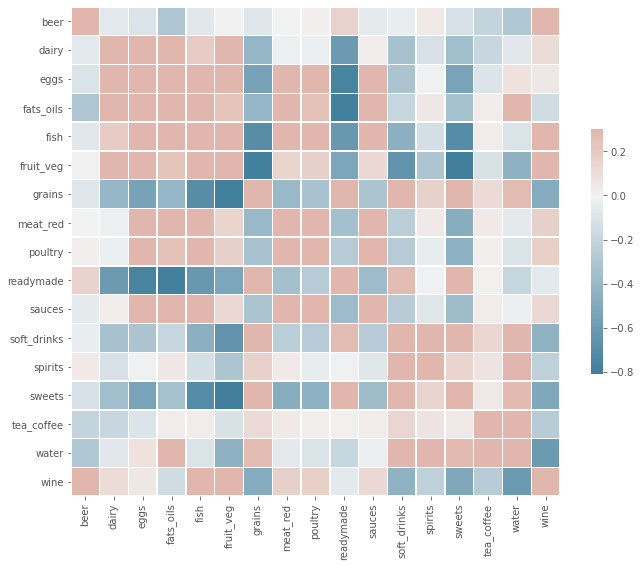

In [6]:
# Compute the correlation matrix
corr = df_cats.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('correlation.png', dpi=300)

In [7]:
df_cats_long = pd.melt(df_cats, value_vars=cols, ignore_index=False)
df_cats_long.rename(columns={
    'variable': 'Category',
    'value': 'Proportion of purchases from category'
}, inplace=True)

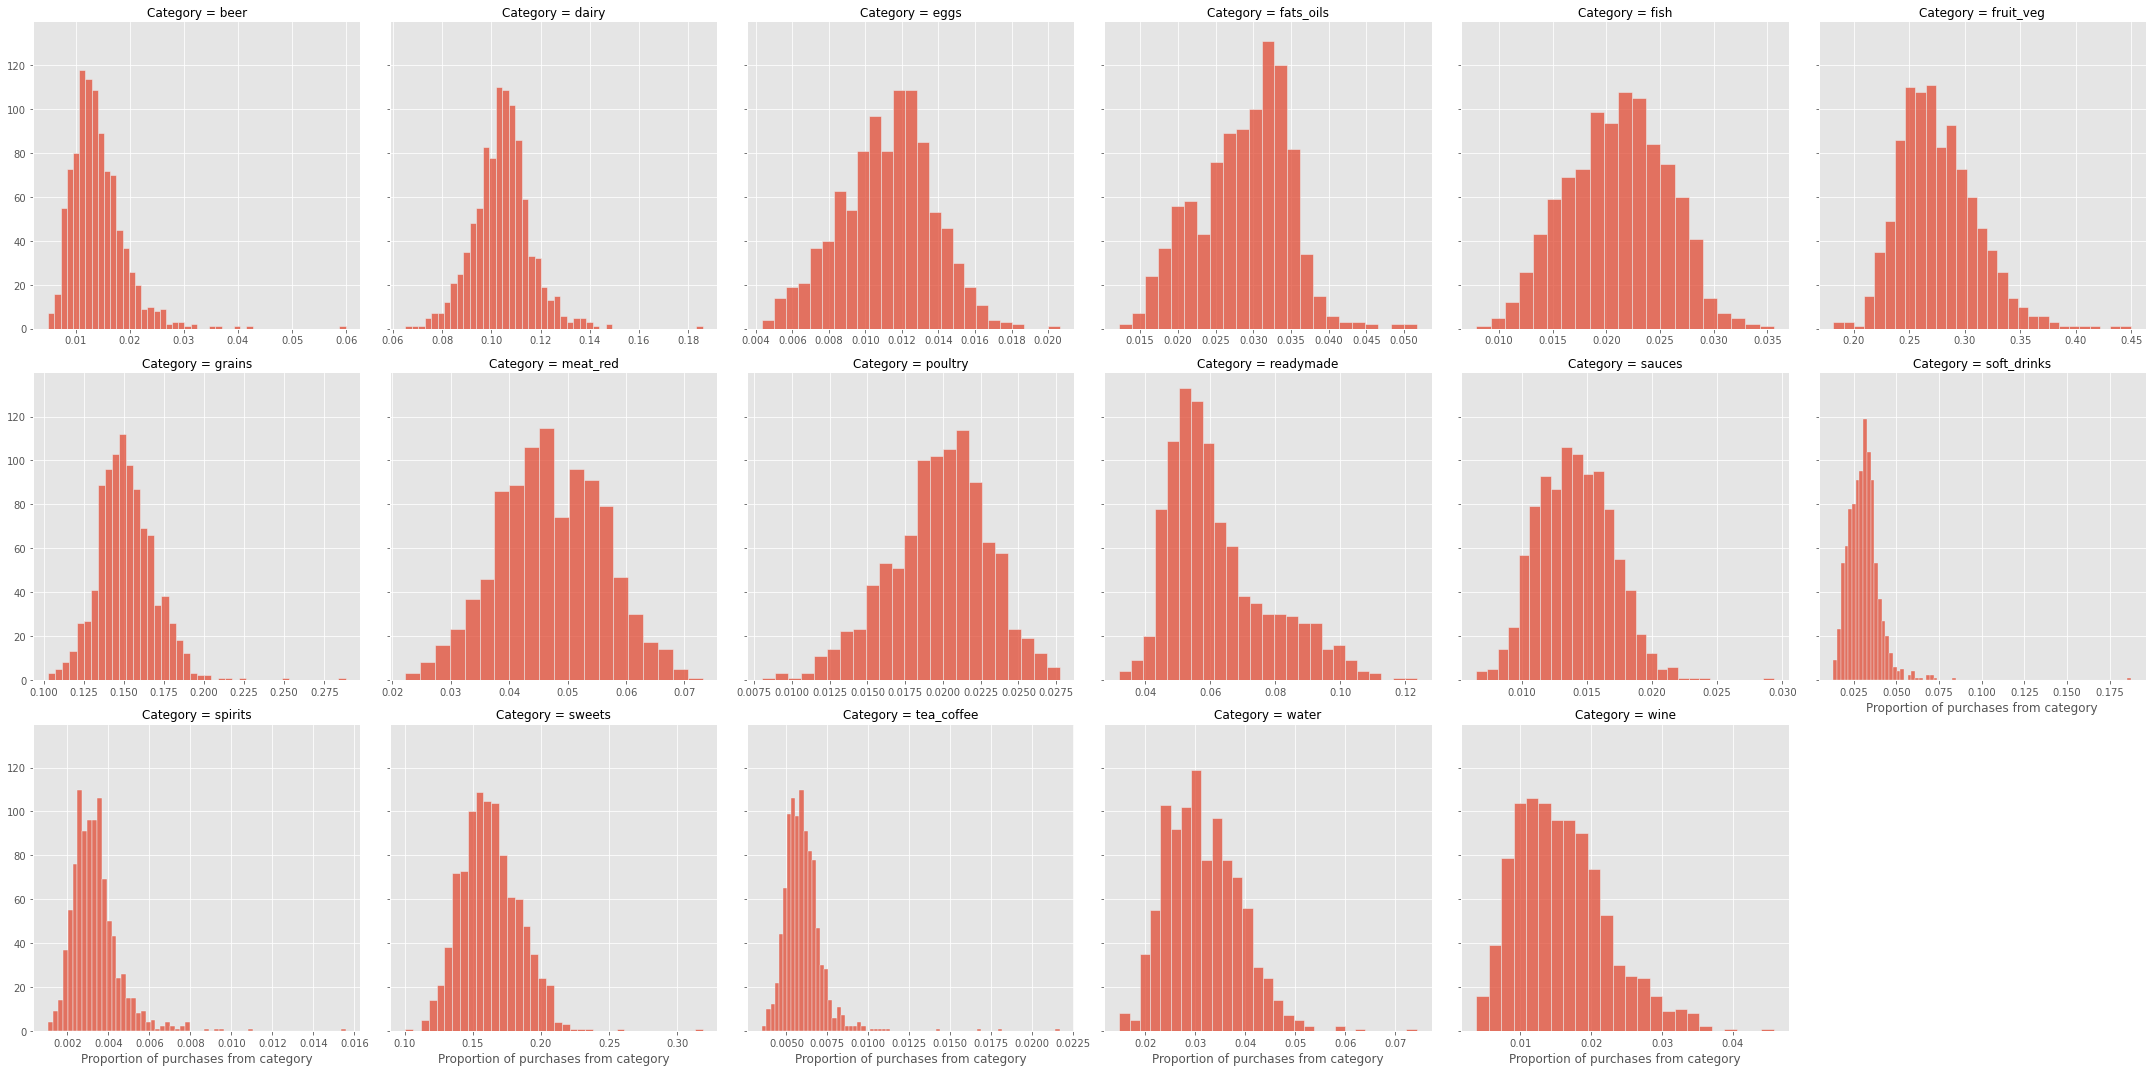

In [8]:
g = sns.FacetGrid(df_cats_long, col="Category", height=5, col_wrap=6, sharex=False)
g.map(sns.histplot, "Proportion of purchases from category")
plt.savefig('category_distributions.png', dpi=160)

## Clustering

In [9]:
rs = RobustScaler()

for c in df_cats.columns.values:
    df_cats[c] = rs.fit_transform(df_cats[c].values.reshape(-1, 1))

......
Largest silhouette score was 0.1837 for k=3


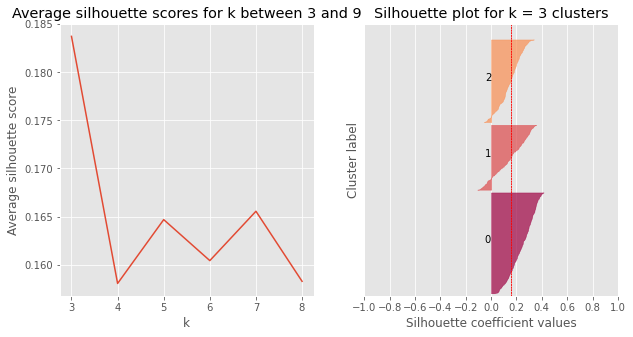

In [10]:
x = []
y = []

for k in range(3,9):
    
    #############
    # Do the clustering using the main columns
    kmeans = sklc.KMeans(n_clusters=k, n_init=25, random_state=42).fit(df_cats)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(df_cats, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

kmeans_output = sklc.KMeans(n_clusters=3, n_init=25).fit(df_cats)
clustering_ids_kmeans = kmeans_output.labels_
silhouette_kmeans = silhouette_score(df_cats,clustering_ids_kmeans)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(y, x)
axes[0].set_title('Average silhouette scores for k between 3 and 9')
axes[0].set_xlabel("k")
axes[0].set_ylabel("Average silhouette score")

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(df_cats, clustering_ids_kmeans)

k_pref = 3

#############

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
axes[1].set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
axes[1].set_ylim([0, df_cats.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clustering_ids_kmeans == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    axes[1].fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    axes[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    axes[1].set_title("Silhouette plot for k = 3 clusters")
    axes[1].set_xlabel("Silhouette coefficient values")
    axes[1].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axes[1].axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    axes[1].set_yticks([])  # Clear the yaxis labels / ticks
    axes[1].set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]
plt.savefig('silhouette.png', dpi=300)

In [11]:
centroids = kmeans_output.cluster_centers_
tr_cent_df = pd.DataFrame(data=centroids, index=['Cluster 1', 'Cluster 2', 'Cluster 3'], columns=df_cats.columns.values)

In [12]:
tr_cent_df

,beer,dairy,eggs,fats_oils,fish,fruit_veg,grains,meat_red,poultry,readymade,sauces,soft_drinks,spirits,sweets,tea_coffee,water,wine
Cluster 1,0.3500,0.3453,0.2735,0.0100,0.3946,0.7314,-0.5927,0.2525,0.1921,-0.1301,0.2569,-0.6020,-0.2389,-0.5250,-0.1830,-0.3942,0.6401
Cluster 2,0.2805,-0.7744,-0.8886,-0.9077,-0.7367,-0.5190,0.9074,-0.5010,-0.5558,1.3571,-0.5629,0.6136,0.2347,0.7828,0.1709,-0.0102,-0.1558
Cluster 3,-0.2388,0.1667,0.1781,0.3792,-0.0084,-0.1878,0.1843,0.1540,0.0259,-0.2038,0.1758,0.3427,0.4896,0.2095,0.4307,0.7355,-0.4240


In [20]:
tr_cent_long = pd.melt(tr_cent_df, value_vars=cols, ignore_index=False)
tr_cent_long['Cluster'] = tr_cent_long.index.values
tr_cent_long.rename(columns={
    'variable': 'Category',
    'value': 'Proportion of purchases in a category (IQR units from category median)'
}, inplace=True)


In [25]:
tr_cent_long.loc[tr_cent_long['Cluster'] == 'Cluster 1', 'Cluster'] = 'Balanced'
tr_cent_long.loc[tr_cent_long['Cluster'] == 'Cluster 2', 'Cluster'] = 'Convenience'
tr_cent_long.loc[tr_cent_long['Cluster'] == 'Cluster 3', 'Cluster'] = 'Drinks, sweets, and fats'

In [31]:
df_cats['cluster'] = pd.Series(clustering_ids_kmeans, index=df_cats.index)

In [32]:
df_cats.groupby('cluster').size()

cluster
0    399
1    257
2    327
dtype: int64

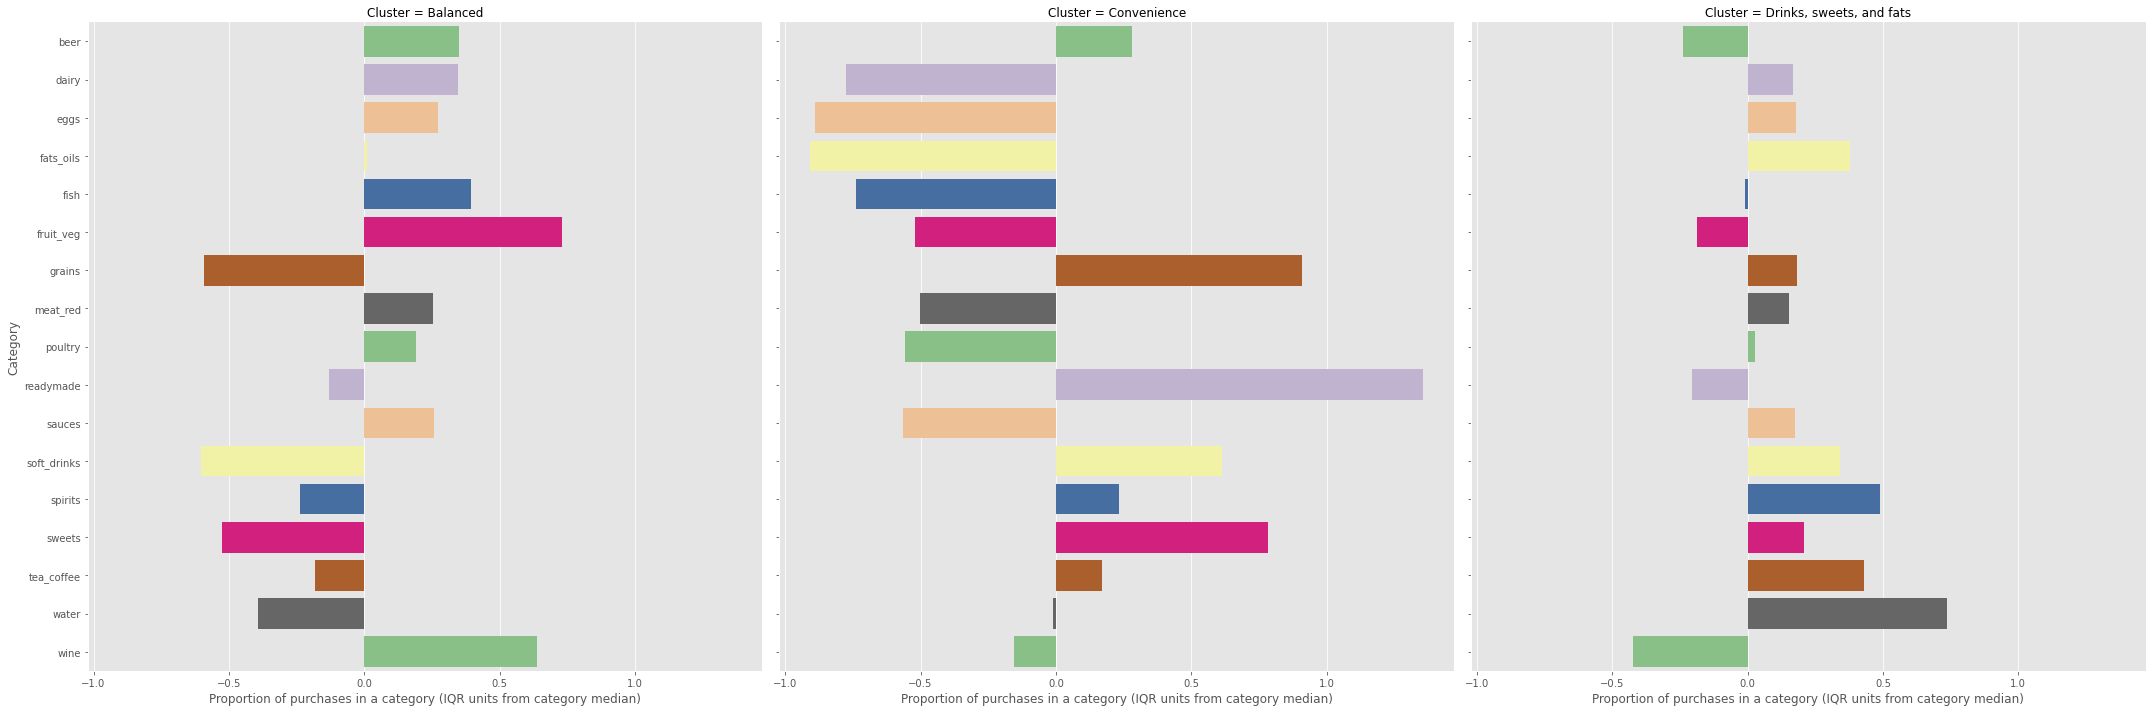

In [30]:
g = sns.FacetGrid(tr_cent_long, col="Cluster", height=10, hue='Category', palette='Accent')
g.map(sns.barplot, 'Proportion of purchases in a category (IQR units from category median)', 'Category', ci=None, order=cols)

plt.savefig('clusters.png', dpi=160)

## Logistic regression

In [33]:
income = pd.read_csv('1netweeklyincomebhc.csv', encoding='ISO-8859-1')

msoa_clusters = df_cats[['cluster']].copy()
msoa_merged = pd.merge(msoa_clusters, income, how='left', left_index=True, right_on='MSOA code')
msoa_merged.set_index('MSOA code', inplace=True)

In [ ]:
msoa_merged.columns.values

In [34]:
X = msoa_merged['Net income before housing costs (£)']
y = msoa_merged['cluster']

In [35]:
logit_model=sm.MNLogit(y,sm.add_constant(X))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 0.786055
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                  983
Model:                        MNLogit   Df Residuals:                      979
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Jan 2021   Pseudo R-squ.:                  0.2741
Time:                        12:36:45   Log-Likelihood:                -772.69
converged:                       True   LL-Null:                       -1064.4
Covariance Type:            nonrobust   LLR p-value:                1.968e-127
                          cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   7.0345      0.677 

In [ ]:
# If daily rental is larger than 4500, it is of Class 'True'. Otherwise, it is in Class 'False'.

###################

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(X, y)
y_pred=logreg.predict(X)

# print the coefficient in the model
print("------------------------------------------")
print("Print the model:")
coef_dict = {}
for coef, feat in zip(logreg.coef_.flatten().tolist(),X.columns):
    coef_dict[feat] = coef
    print(feat, ":", coef)
print("------------------------------------------")
    
acc = sklm.accuracy_score(y,y_pred)
print("Accuracy of the model is: " + str(acc))

# Another evaluation: confusion matrix
print("The confusion matrix is:")
cm=confusion_matrix(y,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1','Predicted:2'],index=['Actual:0','Actual:1','Actual:2'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [38]:
msoa_merged['Net income before housing costs (£)'].describe()

count                                   983.0000
mean                                    652.6246
std                                     120.6535
min                                     440.0000
25%                                     560.0000
50%                                     630.0000
75%                                     730.0000
max                                   1,110.0000
Name: Net income before housing costs (£), dtype: float64